# PVC IMPORT PATTERN FORECASTING : weekly forecast - mean features



## importing dependencies

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


c:\Users\Dhyey2.Patel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Function declaration
Following functions are declared in this section
- function for preprocessing
- function for spliting data into train and testing set
- function for prophet model
- function for XGBoost model 

### Data Preprocessing

In [3]:
def preprocess(dset):

    # selecting only required column
    dset = dset[['ds', 'unitp', 'y']]

    # handling missing values with mean fill method
    dset_mean = dset['unitp'].mean()
    dset['unitp'].fillna(dset_mean, inplace=True)

    dset['cost'] = dset['unitp']*dset['y']

    # formatting date column as per datetime format
    dset['ds'] = pd.to_datetime(dset['ds'], format='mixed')
    dset.sort_values(by='ds', inplace=True)

    # resampling dataset to weekwise frequency
    # resampled_dataset = dset.groupby(pd.Grouper(key='ds', freq='W')).sum().reset_index()
    resampled_dataset = (dset.groupby(pd.Grouper(key='ds', freq='7D', label='left', closed='left')).sum().reset_index())

    # creating lag features
    resampled_dataset['lag_1'] = resampled_dataset['y'].shift(1)
    resampled_dataset.dropna(inplace=True)
    
    return resampled_dataset

### Future Dataset creation: mean features

In [4]:
def future_dset(dset):

    # Create a weekly date range from 2024-01-01 to 2024-03-01
    date_range = pd.date_range(start='2025-07-06', end='2025-09-30', freq='7D')

    future_ds = date_range
    future_df = pd.DataFrame(future_ds, columns=['ds'])
    future_df['ds'] = pd.to_datetime(future_df['ds'])
    
    future_df['cost'] = dset['cost'].mean()

    future_df['lag_1'] = dset['lag_1'].mean()

    future_df.loc[:, 'week'] = future_df['ds'].dt.isocalendar().week
    future_df = future_df[['ds', 'week', 'cost', 'lag_1']]
    
    return future_df

### Training and Testing Data Split
- this function takes the dataset to be predicted
- splits the dataset into training and testing dataset
- split is done in 70:30 ratio
- and returns the training, testing and dataset that can be fitted into the model

In [5]:
def train_test_split(df, size):
    split = int(df['ds'].count()*size)
    
    train = df.iloc[:split+1]
    test = df.iloc[split:]
    
    return train, test

### Prophet: forecasting and plotting
- this function intialises a prophet model
- adds the exogenous variables
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

#### Prophet model hyperparameters tunning


In [6]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
import logging
warnings.filterwarnings("ignore")
logger = logging.getLogger('prophet')
logger.setLevel(logging.CRITICAL)
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

prophet_hyperparams_result = pd.DataFrame(columns=['count', 'params', 'mape_upper', 'mape', 'mape_lower'])

def tunner_prophet(dset,list):

    split = int(dset['ds'].count()*0.8)
    train = dset.iloc[:split+1]
    test = dset.iloc[split:]

    train = train[['ds', 'cost', 'y']]
    test = test[['ds', 'cost', 'y']]
    mtest = test[['ds', 'cost']] 
   
    model = Prophet(interval_width=0.9, changepoint_prior_scale=list[0], seasonality_prior_scale=list[1], seasonality_mode=list[2], changepoint_range=list[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(train)
    forecast = fitted_model.predict(mtest)

    actual = test['y']
    forecast_total = forecast['yhat']
    forecast_upper = forecast['yhat_upper']
    forecast_lower = forecast['yhat_lower']

    # Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(actual,forecast_total) * 100  # convert to %
    mape_upper = mean_absolute_percentage_error(actual,forecast_upper) * 100 
    mape_lower = mean_absolute_percentage_error(actual,forecast_lower) * 100

    return mape, mape_upper, mape_lower

def tuning_prophet(dset, name):

    dset= dset[['ds', 'cost', 'y']]

    # hyperparameters search space defination
    param1 = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 1.0]      # changepoint_prior_scale
    param2 = [0.1, 0.01, 1.0, 5.0, 10.0, 15.0, 20.0, 30.0]       # seasonality_prior_scale
    param3 = ['additive', 'multiplicative']                     # seasonality_mode
    param4 = [0.6, 0.7, 0.8, 0.9, 0.95]                          # changepoint_range

    # calculating total combinations to try
    total_combinations = len(param1) * len(param2) * len(param3) * len(param4)

    # setting best mape as infinity ans best params as none for future update
    best_mape = float('inf')
    best_params = None

    # setting progress bar for total combination 
    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning Prophet", ncols=80) as pbar:
        for mode in param3:
            for cp_range in param4:
                for seas_prior in param2:
                    for cp_prior in param1:
                        params = [cp_prior, seas_prior, mode, cp_range]
                        try:
                            mape, mape_upper, mape_lower = tunner_prophet(dset, params)

                            min_mape = min(mape, mape_upper, mape_lower)
                            if min_mape < best_mape:
                                best_params = params
                                best_mape = min_mape

                            prophet_hyperparams_result.loc[len(prophet_hyperparams_result)] = {'count': count,'name': name, 'params': params,'mape_upper': mape_upper, 'mape': mape, 'mape_lower': mape_lower}

                            count += 1

                        except Exception:
                            pass

                        pbar.update(1)

    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    return best_params, prophet_hyperparams_result


#### Prophet forecast

In [7]:
def prophet_forecast(dset, future, name, params):

    future = future.drop('week', axis=1)

    # train-test forecasting
    model = Prophet(interval_width=0.9, changepoint_prior_scale=params[0], seasonality_prior_scale=params[1], seasonality_mode=params[2], changepoint_range=params[3])
    model.add_regressor('cost', standardize=False)
    fitted_model = model.fit(dset)
    forecast = fitted_model.predict(future)
    future['predicted_import'] = forecast['yhat']
    future['upper_range'] = forecast['yhat_upper']
    future['lower_range'] = forecast['yhat_lower']

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(dset['ds'], dset['y'], color='orange', label='training data', lw=1)
    plt.plot(future['ds'], forecast['yhat'], color='green', label='test forecast', lw=1)
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.4, label='confidence interval')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with hyper-tuned Prophet')
    plt.tight_layout()
    plt.show()

    future['product_grade'] = name
    future['model_name'] = 'Prophet'
    
    return future


### XGBoost :forecasting and plotting
- this function intialises a XGBoost model
- process data for model fitting
- fits the model with training data
- forecast the desired period
- visualises the training and forecasting

this funcation will also display evaluation matrix comparing performance of the model<br>
following are the paramteres used for evaluation
1. Mean Absolute Error
2. Mean Absolute Percentage Error
3. Mean Square Error
4. Root Mean Square Error

#### XGBoost model hyperparameters tunning

In [8]:
# Suppress Prophet logs and warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
logger = logging.getLogger('xgboost')
logger.setLevel(logging.CRITICAL)

xgb_hyperparams_result = pd.DataFrame(columns=['count', 'name', 'params', 'mape'])

def tunner_xgboost(dset, params):

    split = int(dset['ds'].count()*0.8)
    
    train = dset.iloc[:split+1]
    test = dset.iloc[split:]

    train = train[['ds', 'cost', 'lag_1', 'y']]
    test = test[['ds', 'cost', 'lag_1', 'y']]

    # seggregating features and target for model fitting
    x_train, y_train = train[['ds', 'cost', 'lag_1']], train['y']
    y_test = test[['ds', 'cost', 'lag_1']] 

    # extracting features from datetime columns and droping original datetime column
    x_train.loc[:, 'week'] = x_train['ds'].dt.isocalendar().week
    x_train.drop('ds', axis=1, inplace=True)

    y_test.loc[:, 'week'] = y_test['ds'].dt.isocalendar().week
    y_test.drop('ds', axis=1, inplace=True)

    # initialising model and fitting it with training and testing dataset
    model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    model.fit(x_train, y_train)
    
    # forecasting with testing dataset
    forecast = model.predict(y_test)

    mape = mean_absolute_percentage_error(test['y'], forecast) * 100  # convert to %

    return mape

def tuning_xgboost(dset, name):

    dset= dset[['ds', 'cost', 'lag_1', 'y']]

    # hyperparameters search space defination
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    n_estimators = [100, 200, 300, 500, 700]
    max_depth = [3, 5, 7, 9, 11]
    objective = ['reg:squarederror', 'reg:absoluteerror']
    eval_metric = ['rmse', 'mae']

    # calculating total combinations to try
    total_combinations = len(learning_rate) * len(n_estimators) * len(max_depth) * len(objective) * len(eval_metric) 

    # setting best mape as infinity and best params as none for future update
    best_mape = float('inf')
    best_params = None

    count = 1
    # trying each parameters ans finding best with lowest mape score
    with tqdm(total=total_combinations, desc="🔧 Tuning XGBoost", ncols=80) as pbar:
        for em in eval_metric:
            for obj in objective:
                for md in max_depth:
                    for ne in n_estimators:
                        for lr in learning_rate:
                            params = [lr, ne, md, obj, em]
                            try:
                                mape = tunner_xgboost(dset, params)

                                if mape < best_mape:
                                    best_params = params
                                    best_mape = mape

                                xgb_hyperparams_result.loc[len(xgb_hyperparams_result)] = {'count': count,'name': name, 'params': params,'mape': mape}
                         
                                count += 1

                            except Exception:
                                pass
                            
                            pbar.update(1)
                        
    # closing progress bar and returning best params
    # pbar.close()
    print(f"\n✅ Best MAPE: {best_mape:.4f}% with parameters: {best_params}")
    return best_params, xgb_hyperparams_result


#### XGBoost Forecast

In [9]:
def xgboost_forecast(dset, future, name, params):

    # extracting features from datetime columns and droping original datetime column
    dset.loc[:, 'week'] = dset['ds'].dt.isocalendar().week

    # seggregating features and target for model fitting
    x_train, y_train = dset[['week', 'cost', 'lag_1']], dset['y']

    # future date forecasting 
    future_model = XGBRegressor(learning_rate = params[0], n_estimators = params[1], max_depth = params[2], objective=params[3], eval_metric=params[4])
    future_model.fit(x_train, y_train)
    future_fit = future.drop('ds', axis=1)
    future_forecast = future_model.predict(future_fit)
    future['predicted_import'] = future_forecast

    # ploting training, testing, and predicted dataset    
    plt.figure(figsize=(14,5))
    plt.plot(dset['ds'], dset['y'], color='orange', label='training data', lw=1)
    plt.plot(future['ds'], future_forecast, color='green', label='test forecast', lw=1)
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('import quantity')
    plt.title(f'{name} import forecast with hyper-tuned XGBoost')
    plt.tight_layout()
    plt.show()

    future['product_grade'] = name
    future['model_name'] = 'XGBoost'

    return future


## Loadind data and preprocessing

In [10]:
df = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/PVC-suspension_lead_time.xlsx')
df = df[['ds', 'k', 'unitp', 'y']]

# converting dates to datetime format & sorting
df['ds'] = pd.to_datetime(df['ds'], format='mixed')
df.sort_values(by='ds', inplace=True)

# loading maping dataset
map = pd.read_excel('C:/Users/Dhyey2.Patel/Desktop/Dhyey2.Patel/PVC_import_analysis_&_forecasting/data/preprocessed data/cat_to_num_mapping.xlsx', engine='openpyxl')

# making dictionary of mapping dataset
k_map =  dict(zip(map['k_level'], map['k_code']))

# mapping grades of df to their code from mapping dataset
df['k_code'] = df['k'].map(k_map)

# dropping previous grade column
df.drop('k', axis=1, inplace=True)

# This will store the final forecast results
prophet_forecast_df = pd.DataFrame(columns=['ds', 'product_grade','cost','lag_1', 'upper_range', 'predicted_import', 'lower_range', 'model_name'])
xgb_forecast_df = pd.DataFrame(columns=['ds', 'product_grade','cost','lag_1', 'upper_range', 'predicted_import', 'lower_range', 'model_name'])
prophet_params_df = pd.DataFrame(columns=['count', 'params', 'mape_upper', 'mape', 'mape_lower'])
xgb_params_df = pd.DataFrame(columns=['count', 'params', 'mape'])

print(df.tail())
print('Total import: ',df['y'].sum())

              ds  unitp        y  k_code
97912 2025-06-04  684.0  280.000     2.0
98220 2025-06-04  676.0   12.398     2.0
98221 2025-06-04  676.0   10.198     2.0
97911 2025-06-04  684.0  280.000     2.0
98199 2025-06-04  676.0  117.404     2.0
Total import:  13013663.026074188


## Forecasting individual K-Level

In [11]:
def k_level_forecast(code, name, p_params, x_params):   

    dset = df[(df['k_code'] == code)]
    
    resampled_dset = preprocess(dset)

    future_df = future_dset(resampled_dset)
    
    if (p_params == None):
        prophet_params, prophet_params_df = tuning_prophet(resampled_dset, name)
    else:
        prophet_params_df = None
        prophet_params = p_params

    ppht_forecast = prophet_forecast(resampled_dset, future_df, name, prophet_params)
    print('Prophet Ouput: ')
    print(ppht_forecast)


    if (x_params == None):
        xgboost_params, xgb_params_df = tuning_xgboost(resampled_dset, name)
    else:
        xgb_params_df = None
        xgboost_params = x_params

    xgb_forecast = xgboost_forecast(resampled_dset, future_df, name, xgboost_params)
    print('XGBoost output: ')
    print(xgb_forecast)

    return ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df

### Very High K

15:02:47 - cmdstanpy - INFO - Chain [1] start processing
15:02:47 - cmdstanpy - INFO - Chain [1] done processing
15:02:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:02:47 - cmdstanpy - INFO - Chain [1] start processing
15:02:56 - cmdstanpy - INFO - Chain [1] done processing


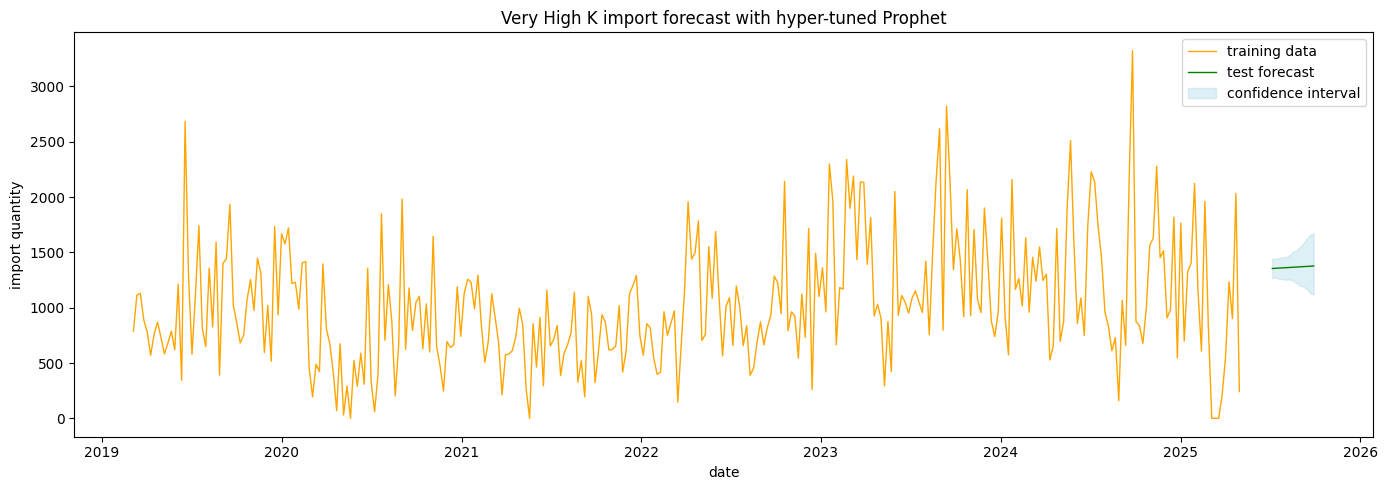

Prophet Ouput: 
           ds          cost        lag_1  predicted_import  upper_range  \
0  2025-07-06  1.061831e+06  1030.525019       1354.331933  1444.889965   
1  2025-07-13  1.061831e+06  1030.525019       1356.209009  1442.381991   
2  2025-07-20  1.061831e+06  1030.525019       1358.086085  1448.533813   
3  2025-07-27  1.061831e+06  1030.525019       1359.963160  1454.269212   
4  2025-08-03  1.061831e+06  1030.525019       1361.840236  1458.071101   
5  2025-08-10  1.061831e+06  1030.525019       1363.717311  1475.124144   
6  2025-08-17  1.061831e+06  1030.525019       1365.594387  1505.536481   
7  2025-08-24  1.061831e+06  1030.525019       1367.471463  1514.652905   
8  2025-08-31  1.061831e+06  1030.525019       1369.348538  1548.786316   
9  2025-09-07  1.061831e+06  1030.525019       1371.225614  1581.011524   
10 2025-09-14  1.061831e+06  1030.525019       1373.102689  1623.857328   
11 2025-09-21  1.061831e+06  1030.525019       1374.979765  1662.525296   
12 2025-0

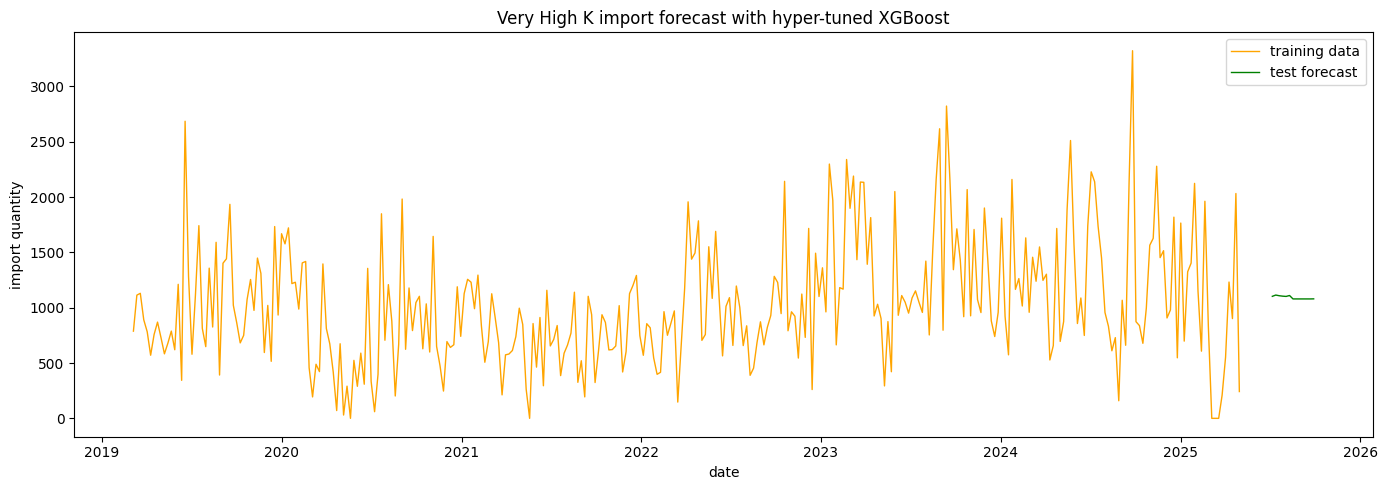

XGBoost output: 
           ds  week          cost        lag_1  predicted_import  \
0  2025-07-06    27  1.061831e+06  1030.525019       1102.740112   
1  2025-07-13    28  1.061831e+06  1030.525019       1114.299683   
2  2025-07-20    29  1.061831e+06  1030.525019       1108.145630   
3  2025-07-27    30  1.061831e+06  1030.525019       1104.288452   
4  2025-08-03    31  1.061831e+06  1030.525019       1101.937622   
5  2025-08-10    32  1.061831e+06  1030.525019       1110.175537   
6  2025-08-17    33  1.061831e+06  1030.525019       1079.281128   
7  2025-08-24    34  1.061831e+06  1030.525019       1079.259888   
8  2025-08-31    35  1.061831e+06  1030.525019       1079.259888   
9  2025-09-07    36  1.061831e+06  1030.525019       1079.259888   
10 2025-09-14    37  1.061831e+06  1030.525019       1079.259888   
11 2025-09-21    38  1.061831e+06  1030.525019       1079.197388   
12 2025-09-28    39  1.061831e+06  1030.525019       1079.856812   

   product_grade model_name  


In [12]:
prophet_params = [0.001, 0.01, 'multiplicative', 0.8]
xgb_params = [0.1, 200, 11, 'reg:squarederror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params, xgb_params = k_level_forecast(1, 'Very High K', prophet_params, xgb_params) 

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)

### High K

15:02:58 - cmdstanpy - INFO - Chain [1] start processing
15:02:58 - cmdstanpy - INFO - Chain [1] done processing
15:02:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:02:58 - cmdstanpy - INFO - Chain [1] start processing
15:03:00 - cmdstanpy - INFO - Chain [1] done processing


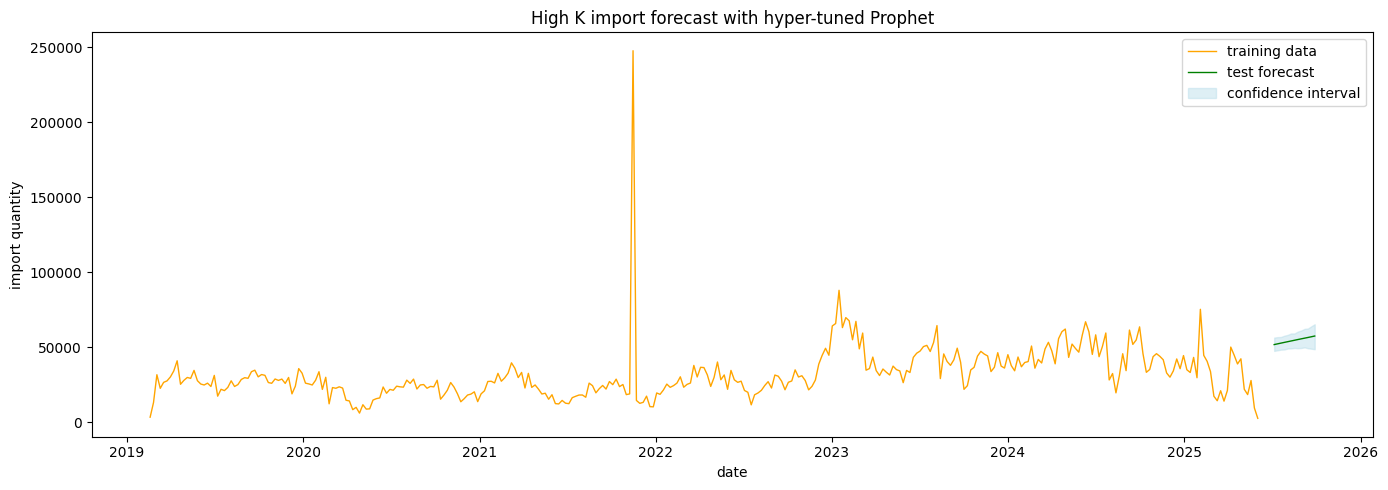

Prophet Ouput: 
           ds          cost         lag_1  predicted_import   upper_range  \
0  2025-07-06  3.061361e+07  31910.187966      51794.413754  56452.864490   
1  2025-07-13  3.061361e+07  31910.187966      52279.996582  56746.067106   
2  2025-07-20  3.061361e+07  31910.187966      52766.073905  56859.767212   
3  2025-07-27  3.061361e+07  31910.187966      53245.258254  57697.073035   
4  2025-08-03  3.061361e+07  31910.187966      53717.293824  58253.710850   
5  2025-08-10  3.061361e+07  31910.187966      54189.532340  59197.720837   
6  2025-08-17  3.061361e+07  31910.187966      54667.223292  59191.981067   
7  2025-08-24  3.061361e+07  31910.187966      55145.192348  60445.222374   
8  2025-08-31  3.061361e+07  31910.187966      55613.012205  61161.746974   
9  2025-09-07  3.061361e+07  31910.187966      56069.256209  62270.260435   
10 2025-09-14  3.061361e+07  31910.187966      56526.852966  62515.972898   
11 2025-09-21  3.061361e+07  31910.187966      57000.190210 

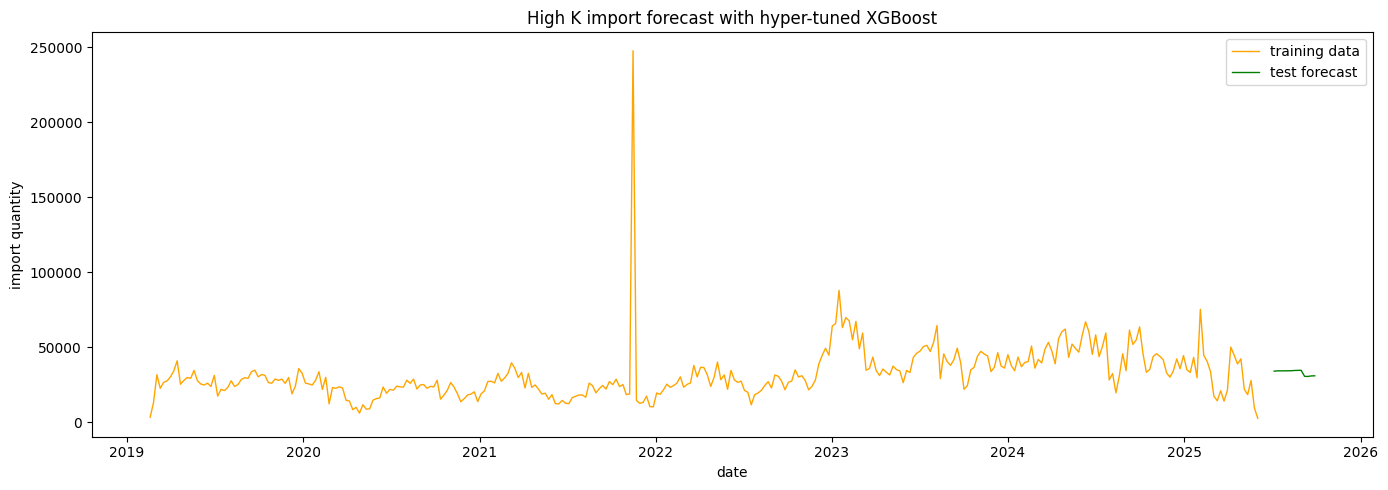

XGBoost output: 
           ds  week          cost         lag_1  predicted_import  \
0  2025-07-06    27  3.061361e+07  31910.187966      34074.890625   
1  2025-07-13    28  3.061361e+07  31910.187966      34287.308594   
2  2025-07-20    29  3.061361e+07  31910.187966      34287.617188   
3  2025-07-27    30  3.061361e+07  31910.187966      34289.941406   
4  2025-08-03    31  3.061361e+07  31910.187966      34331.925781   
5  2025-08-10    32  3.061361e+07  31910.187966      34339.480469   
6  2025-08-17    33  3.061361e+07  31910.187966      34529.660156   
7  2025-08-24    34  3.061361e+07  31910.187966      34601.750000   
8  2025-08-31    35  3.061361e+07  31910.187966      34631.667969   
9  2025-09-07    36  3.061361e+07  31910.187966      30605.242188   
10 2025-09-14    37  3.061361e+07  31910.187966      30551.937500   
11 2025-09-21    38  3.061361e+07  31910.187966      30899.056641   
12 2025-09-28    39  3.061361e+07  31910.187966      30974.714844   

   product_grade

In [13]:
prophet_params = [0.1, 0.01, 'multiplicative', 0.95]
xgb_params = [0.3, 700, 11, 'reg:squarederror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df = k_level_forecast(2, 'High K', prophet_params, xgb_params)

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)

### Medium K

15:03:03 - cmdstanpy - INFO - Chain [1] start processing
15:03:03 - cmdstanpy - INFO - Chain [1] done processing
15:03:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:03:03 - cmdstanpy - INFO - Chain [1] start processing
15:03:14 - cmdstanpy - INFO - Chain [1] done processing


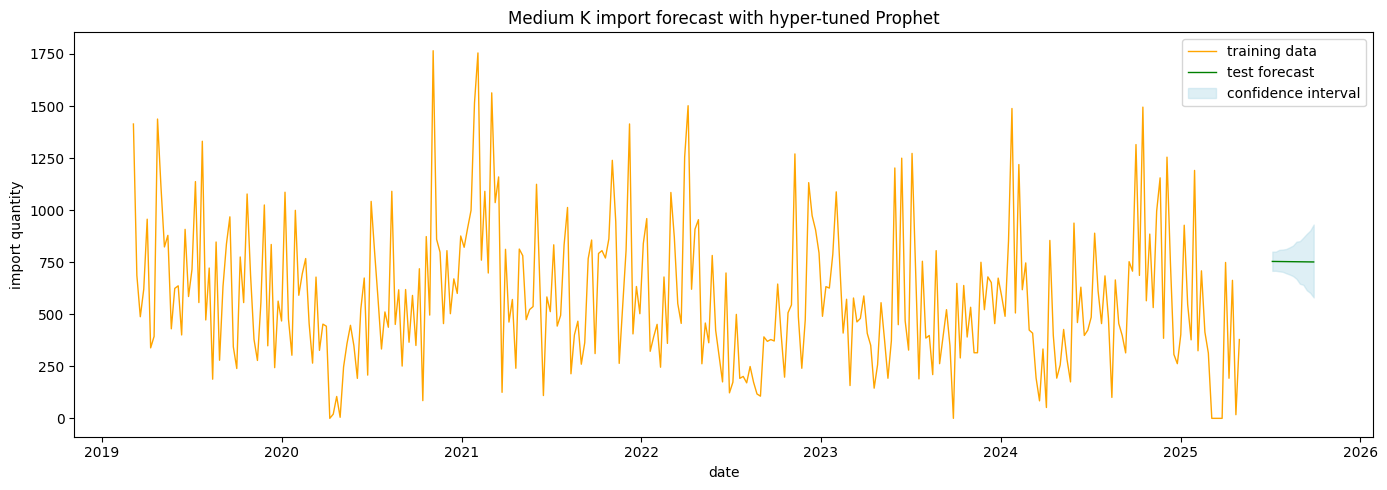

Prophet Ouput: 
           ds           cost       lag_1  predicted_import  upper_range  \
0  2025-07-06  629310.603033  588.398225        753.584312   800.615959   
1  2025-07-13  629310.603033  588.398225        753.379884   800.441508   
2  2025-07-20  629310.603033  588.398225        753.175456   809.069981   
3  2025-07-27  629310.603033  588.398225        752.971029   810.511696   
4  2025-08-03  629310.603033  588.398225        752.766604   813.133755   
5  2025-08-10  629310.603033  588.398225        752.562180   820.980167   
6  2025-08-17  629310.603033  588.398225        752.357755   829.529287   
7  2025-08-24  629310.603033  588.398225        752.153327   848.324270   
8  2025-08-31  629310.603033  588.398225        751.948899   851.012053   
9  2025-09-07  629310.603033  588.398225        751.744472   867.901491   
10 2025-09-14  629310.603033  588.398225        751.540046   885.874913   
11 2025-09-21  629310.603033  588.398225        751.335622   901.534737   
12 2025-0

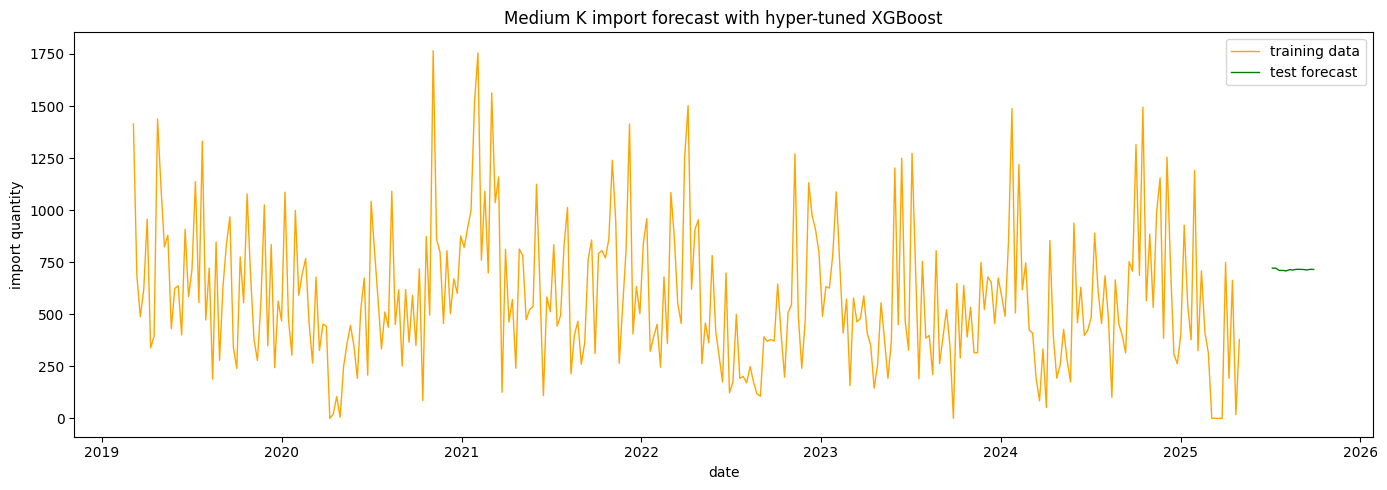

XGBoost output: 
           ds  week           cost       lag_1  predicted_import  \
0  2025-07-06    27  629310.603033  588.398225        721.432007   
1  2025-07-13    28  629310.603033  588.398225        721.432007   
2  2025-07-20    29  629310.603033  588.398225        710.454224   
3  2025-07-27    30  629310.603033  588.398225        710.454224   
4  2025-08-03    31  629310.603033  588.398225        708.074829   
5  2025-08-10    32  629310.603033  588.398225        714.047729   
6  2025-08-17    33  629310.603033  588.398225        712.447021   
7  2025-08-24    34  629310.603033  588.398225        715.671753   
8  2025-08-31    35  629310.603033  588.398225        715.710693   
9  2025-09-07    36  629310.603033  588.398225        714.854858   
10 2025-09-14    37  629310.603033  588.398225        712.370239   
11 2025-09-21    38  629310.603033  588.398225        715.967468   
12 2025-09-28    39  629310.603033  588.398225        715.089050   

   product_grade model_name  


In [14]:
prophet_params = [0.005, 1.0, 'multiplicative', 0.7]
xgb_params = [0.3, 500, 3, 'reg:absoluteerror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df = k_level_forecast(3, 'Medium K', prophet_params, xgb_params)

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)


### Low K

15:03:15 - cmdstanpy - INFO - Chain [1] start processing
15:03:16 - cmdstanpy - INFO - Chain [1] done processing
15:03:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:03:16 - cmdstanpy - INFO - Chain [1] start processing
15:03:35 - cmdstanpy - INFO - Chain [1] done processing


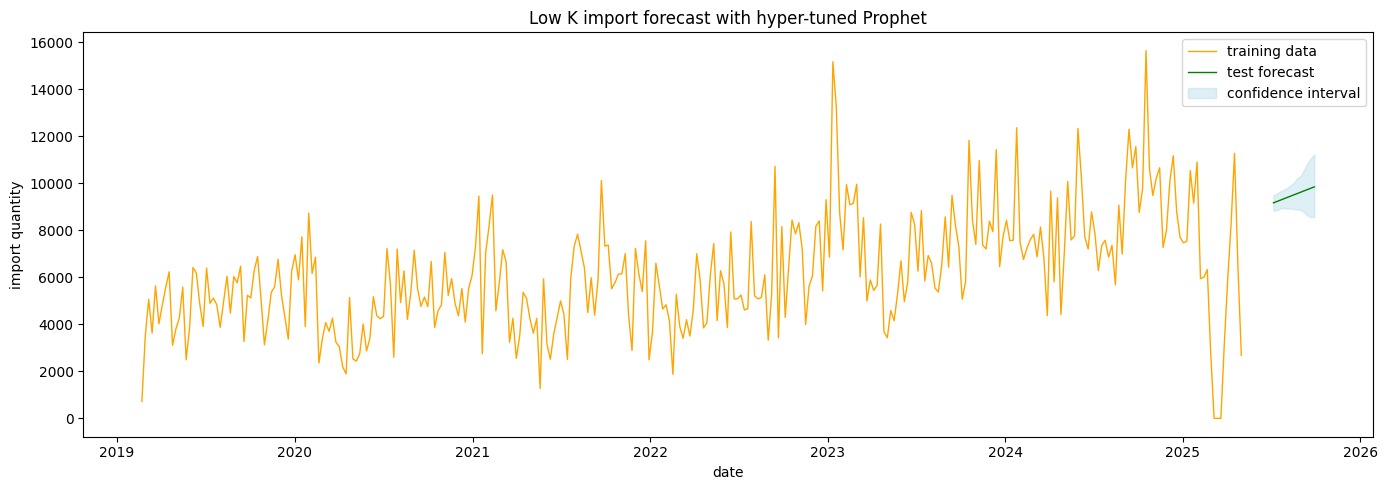

Prophet Ouput: 
           ds          cost        lag_1  predicted_import   upper_range  \
0  2025-07-06  6.274404e+06  6129.775311       9164.115355   9487.649103   
1  2025-07-13  6.274404e+06  6129.775311       9220.719651   9560.227476   
2  2025-07-20  6.274404e+06  6129.775311       9277.323947   9648.129379   
3  2025-07-27  6.274404e+06  6129.775311       9333.928243   9715.700851   
4  2025-08-03  6.274404e+06  6129.775311       9390.532539   9798.696226   
5  2025-08-10  6.274404e+06  6129.775311       9447.136835   9907.200612   
6  2025-08-17  6.274404e+06  6129.775311       9503.741131  10014.790335   
7  2025-08-24  6.274404e+06  6129.775311       9560.345427  10218.956746   
8  2025-08-31  6.274404e+06  6129.775311       9616.949722  10306.099343   
9  2025-09-07  6.274404e+06  6129.775311       9673.554018  10562.798093   
10 2025-09-14  6.274404e+06  6129.775311       9730.158314  10842.841525   
11 2025-09-21  6.274404e+06  6129.775311       9786.762610  11052.095015

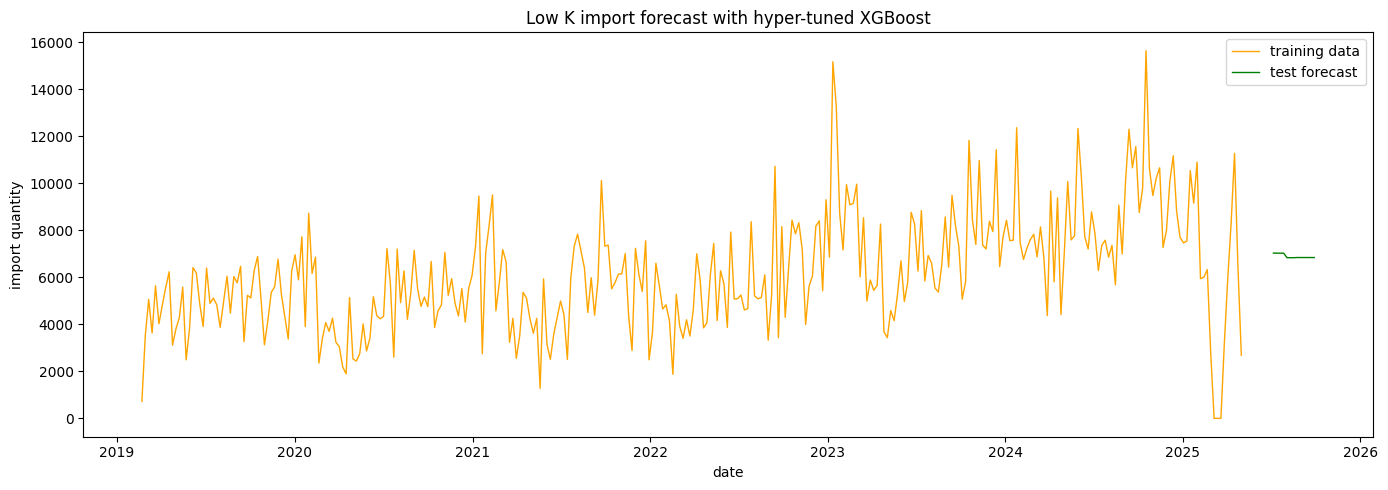

XGBoost output: 
           ds  week          cost        lag_1  predicted_import  \
0  2025-07-06    27  6.274404e+06  6129.775311       7027.659668   
1  2025-07-13    28  6.274404e+06  6129.775311       7023.959473   
2  2025-07-20    29  6.274404e+06  6129.775311       7024.042480   
3  2025-07-27    30  6.274404e+06  6129.775311       7024.042480   
4  2025-08-03    31  6.274404e+06  6129.775311       6831.907715   
5  2025-08-10    32  6.274404e+06  6129.775311       6831.907715   
6  2025-08-17    33  6.274404e+06  6129.775311       6831.907715   
7  2025-08-24    34  6.274404e+06  6129.775311       6838.818848   
8  2025-08-31    35  6.274404e+06  6129.775311       6838.818848   
9  2025-09-07    36  6.274404e+06  6129.775311       6838.818848   
10 2025-09-14    37  6.274404e+06  6129.775311       6838.818848   
11 2025-09-21    38  6.274404e+06  6129.775311       6838.167480   
12 2025-09-28    39  6.274404e+06  6129.775311       6837.777832   

   product_grade model_name  


In [15]:
prophet_params = [0.005, 0.01, 'multiplicative', 0.95]
xgb_params = [0.3, 700, 3, 'reg:absoluteerror', 'rmse']

ppht_forecast, xgb_forecast, prophet_params_df, xgb_params_df = k_level_forecast(4, 'Low K', prophet_params, xgb_params)

prophet_forecast_df = pd.concat([prophet_forecast_df, ppht_forecast], ignore_index=True)
xgb_forecast_df = pd.concat([xgb_forecast_df, xgb_forecast], ignore_index=True)

# prophet_params_df = pd.concat([prophet_params_df, prophet_params], ignore_index=True)
# xgb_params_df = pd.concat([xgb_params_df, xgb_params], ignore_index=True)

In [16]:
print(prophet_forecast_df.head())
# print(prophet_params_df.head())

          ds product_grade          cost        lag_1  upper_range  \
0 2025-07-06   Very High K  1.061831e+06  1030.525019  1444.889965   
1 2025-07-13   Very High K  1.061831e+06  1030.525019  1442.381991   
2 2025-07-20   Very High K  1.061831e+06  1030.525019  1448.533813   
3 2025-07-27   Very High K  1.061831e+06  1030.525019  1454.269212   
4 2025-08-03   Very High K  1.061831e+06  1030.525019  1458.071101   

   predicted_import  lower_range model_name  
0       1354.331933  1268.838828    Prophet  
1       1356.209009  1273.452569    Prophet  
2       1358.086085  1260.820303    Prophet  
3       1359.963160  1258.348017    Prophet  
4       1361.840236  1252.119150    Prophet  


In [17]:
print(xgb_forecast_df.head())
# print(xgb_params_df.head())

          ds product_grade          cost        lag_1 upper_range  \
0 2025-07-06   Very High K  1.061831e+06  1030.525019         NaN   
1 2025-07-13   Very High K  1.061831e+06  1030.525019         NaN   
2 2025-07-20   Very High K  1.061831e+06  1030.525019         NaN   
3 2025-07-27   Very High K  1.061831e+06  1030.525019         NaN   
4 2025-08-03   Very High K  1.061831e+06  1030.525019         NaN   

   predicted_import lower_range model_name  week  
0       1102.740112         NaN    XGBoost    27  
1       1114.299683         NaN    XGBoost    28  
2       1108.145630         NaN    XGBoost    29  
3       1104.288452         NaN    XGBoost    30  
4       1101.937622         NaN    XGBoost    31  


In [18]:
# prophet_forecast_df.to_excel('prophet_forecast_output(feature-forecast).xlsx', index=False)
# xgb_forecast_df.to_excel('xgb_forecast_output(feature-forecast).xlsx', index=False)

# prophet_params_df.to_excel('prophet_hyperparams.xlsx', index=False)
# xgb_params_df.to_excel('xgb_hyperparams.xlsx', index=False)